In [391]:
%matplotlib inline 

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import datetime
import timeit
import math

import sklearn
import statsmodels as sm
import scipy.stats as stats 
import colormaps as cmaps

import shapefile as sf
from matplotlib.patches import Polygon
import mpld3

from pyproj import Proj
from censusgeocode import CensusGeocode
from matplotlib.collections import PatchCollection

import smopy

- Read in the information from the Historic Secured Property Tax Rolls. 
- We only care about R-2 properties
    - Apartments 
    - Condominiums 
    - Residential hotels 
    - All required to have three or more units

First question, how do we extract the R-2 properties from the data set of properties? 
- Can set limits on UNITS
- Can set limits on Property Codes

In [392]:
property_roll = pd.read_csv('challenge_datasets/Historic_Secured_Property_Tax_Rolls.csv')

In [393]:
# Multi-family residential codes: 
mfc = ['A', 'CO', 'DA', 'DD', 'DF', 'F', 'FA', 'F2', 'OA', 'TIA', 'TIF', 'XV', 'AC', '']
# Condominimum residential codes: 
cc = ['Z', 'ZBM', 'LZ', 'LZBM', 'IZ', 'GZ', 'OZ', 'BZ']
# Residential Hotel codes 
rhc = ['RH']

# R2 codes 
r2_codes = mfc + cc + rhc

In [394]:
r2_index_yearly = np.where((property_roll['Property Class Code'].isin(r2_codes)==True) 
             & (property_roll['Closed Roll Fiscal Year']==2007)
             & (property_roll['Number of Units']>=3))[0]
len(r2_index_yearly)

19258

When I run the query above, I get around 19,000 properties for various years. Interestingly, this drops by about half when I run it for the year 2014. Perhaps the file wasn't fully complete for that year? 

The prompt specified that there are around 21,000 R-2s in SF, so I'm fairly close in my yearly property roll numbers. 

In [395]:
# All r2 properties over all years
r2_index = np.where((property_roll['Property Class Code'].isin(r2_codes)==True) 
             & (property_roll['Number of Units']>=3))[0]
len(r2_index)

pr = property_roll.loc[r2_index]

pr.reset_index(drop=True, inplace=True)

The fire inspection and property roll data lists the addresses in different ways. Below I modify the addresses in the property roll to make it easier to match with the fire data.

In [396]:
pr['street_type'] = pr['Property Location'].str.strip().str.replace('0000', '').str.split(' ').str[-1:].str[0].str.replace('AV', 'AVE')

pr['bulk'] = pr['Property Location'].str.replace('0000', '').str.strip().str.split(' ').str[:-1]

pr['bulk'] = [' '.join(x) for x in pr['bulk']]

pr['Address'] = pr['bulk'].str.strip() + ' ' + pr['street_type']

In [397]:
pr['year'] = pr['Closed Roll Fiscal Year']

Now that I have a list of R-2 properties by year, I want to link this up with Fire Inspection/Violation information

For the Fire Inspection data, we have the following useful info: 
- Address
- Station Area 
- Complaint Number 
- Violation number 
- Neighborhood District 
- Location 
- Sent to Bureau of Delinquent Revenue

In [398]:
finspect = pd.read_csv('challenge_datasets/Fire_Inspections_after_01_01_2011.csv')

In [399]:
# I'm extracting the Inspection year so I can match with the property roll data on a yearly basis.
finspect['year'] = pd.to_datetime(finspect['Inspection Start Date'], format="%m/%d/%Y", utc=False).dt.year.astype(float)

Modify the Fire Inspection addresses slightly to match them up with the Property records

In [400]:
finspect['Address_orig'] = finspect['Address']

In [401]:
finspect['Address'] = finspect['Address'].str.replace('  - ', ' ').str.upper().str.replace('   ', ' ').str.replace('  ', ' ')

Number of Inspections per Year

In [402]:
finspect['year'].value_counts().sort_index()

2011.0    18836
2012.0    17967
2013.0    18495
2014.0    18601
2015.0    21630
2016.0    24957
2017.0      523
Name: year, dtype: int64

Number of Inspections per Year by Type

- The majority of inspections are dbi/annual/r2 company inspections. 
- In fourth place are inspections stemming from complaints. 

9.8% of all fire inspections are prompted by a citizen/resident complaint.

In [403]:
finspect['Inspection Type Description'].value_counts().astype(float) / float(len(finspect))

dbi inspection                                     0.229545
permit annual inspection                           0.172772
r1 company inspection                              0.168872
complaint inspection                               0.098274
permit approval inspection                         0.053219
dph referral - non hazmat ref. insp.               0.047013
place of assembly detail                           0.029717
high rise annual inspection                        0.029518
police dept. ref. insp.                            0.028609
violation reinspection - nov                       0.018180
r2 company inspection                              0.017462
additional non-dbi inspection/plan review hours    0.012255
school annual inspection                           0.011817
follow up inspection                               0.010065
highrise report writing                            0.009851
high rise follow up inspection                     0.007925
reinspection - no fee                   

In [404]:
finspect[['year', 'Inspection Type Description', 'Address']].groupby(['year', 'Inspection Type Description'], as_index=False).agg('count').sort_values(by=['year', 'Address'], ascending=False)

,year,Inspection Type Description,Address
314,2017.0,permit annual inspection,236
307,2017.0,dbi inspection,78
311,2017.0,high rise annual inspection,50
306,2017.0,complaint inspection,40
315,2017.0,permit approval inspection,36
321,2017.0,violation reinspection - nov,32
308,2017.0,dph referral - non hazmat ref. insp.,13
316,2017.0,police dept. ref. insp.,10
317,2017.0,reinspection - no fee,9
313,2017.0,oshpod ref. insp.,5


Now we have some sense of the patterns of inspections. But what about the patterns for R-2 properties?

In [405]:
r2_inspections = pd.merge(finspect, pr, how='inner', on=['Address', 'year'])

In [406]:
float(len(r2_inspections))*100. / float(len(finspect))

4.025320430711766

The merge above indicates that only 4% of all fire inspections are done on R-2 properties. Below, I can see that of the R-2 inspections, the majority are due to r1 company inspection. That sounds a bit wrong because of the R1/R2 discrepancy, but some googling suggests that the r1 company inspection is for residential buildings (http://www.sfaa.org/may2012/1205_harvey.html) 

In [408]:
r2_inspections['Inspection Type Description'].value_counts().astype(float) / float(len(r2_inspections))

r1 company inspection                   0.751591
complaint inspection                    0.103880
dbi inspection                          0.044960
high rise annual inspection             0.020324
permit annual inspection                0.014987
permit approval inspection              0.012728
reinspection - no fee                   0.011086
dph referral - non hazmat ref. insp.    0.006775
high rise follow up inspection          0.005338
violation reinspection - nov            0.005132
highrise report writing                 0.004517
place of assembly detail                0.003901
police dept. ref. insp.                 0.002669
follow up inspection                    0.002464
ul certification                        0.002053
facility emergency plan review          0.001642
dbi - job notification                  0.001437
traccess installation                   0.000821
dss-community care license              0.000821
initial inspection                      0.000821
on-site consultation

So now we know that the majority of R-2 property inspections appear to be routine r1 company inspections. Only around 500 are complain related. Finally, note that around 220 are related to the Department of Building Inspections (DBI). So there already is some cross-pollination between the two departments and their inspections.

We also have information about resident complaints referred to the fire department. 

Some Useful Features: 
- Complaint ID (for matching)
- Complaint Number (for matching)
- Complaint Item Type (Description)
- Address
- Received Date / Disposition Date 

In [409]:
fcomplaints = pd.read_csv('challenge_datasets/Fire_Safety_Complaints.csv')

In [410]:
fcomplaints['year'] = pd.to_datetime(fcomplaints['Received Date'], format="%m/%d/%Y", utc=False).dt.year.astype(float)

In [411]:
fcomplaints['Address_orig'] = fcomplaints['Address']

In [412]:
fcomplaints['Address'] = fcomplaints['Address'].str.replace('  - ', ' ').str.upper().str.replace('   ', ' ').str.replace('  ', ' ')

In [413]:
r2_complaints = pd.merge(fcomplaints, pr, how='inner', on=['Address', 'year'])

In [414]:
float(len(r2_complaints))*100. / float(len(fcomplaints))

6.605922551252847

Approximately 7% of all complaints originate from R-2 properties. 

But do complaints link to violations?

In [415]:
fviolations = pd.read_csv('challenge_datasets/Fire_Violations.csv')

Violation information 

Some useful features: 
- Violation ID 
- Violation Number 
- Violation Date 
- Inspection Number 
- Address 


In [416]:
fviolations['Address_orig'] = fviolations['Address']

In [417]:
fviolations['Address'] = fviolations['Address'].str.replace('  - ', ' ').str.upper().str.replace('   ', ' ').str.replace('  ', ' ')

In [418]:
fviolations['year'] = pd.to_datetime(fviolations['Violation Date'], format="%m/%d/%Y", utc=False).dt.year.astype(float)

In [419]:
r2_violations = pd.merge(fviolations, pr, how='inner', on=['Address', 'year'])

In [420]:
float(len(r2_violations))*100. / float(len(fviolations))

3.7974683544303796

Approximately 4% of all violations originate in R-2 properties. Considering that they make up ~4% of all the inspections, this makes some sense. But they account for a larger fraction of the complaints...

In [421]:
np.where((finspect['Complaint Number'].isnull() == False) & (finspect['Violation Number'].isnull() == False))

(array([], dtype=int64),)

I'm not finding any inspections where there is both a Complaint and Violation number. Does this mean that there are no inspections prompted by complaints that find violations? That seems not correct...

In [422]:
f1 = pd.merge(finspect, fcomplaints[['Complaint Number', 'Complaint Item Type', 'Received Date']], how='left', on='Complaint Number')

In [423]:
f2 = pd.merge(f1, fviolations[['Violation Number', 'Violation Date', 'Violation Item', 
                              'Violation Item Description', 'Status', 'Close Date']], how='left', on='Violation Number')

f2 has information about all of the inspections and violations

In [424]:
len(finspect), len(fcomplaints), len(fviolations), len(f2)

(121009, 28974, 11692, 133162)

The merged data set agrees. There appear to be no Violations associated with Complaints. However, the top categories for violations are related to reinspection Inspection types. 

Presumably, once a violation is identified, it gets recategorized for reinspection? Not terribly useful for my work right now, I'm afraid.

In [425]:
f2[['Inspection Type Description', 'Violation Number']].groupby('Inspection Type Description').agg('count').sort_values(by='Violation Number', ascending=False)

,Violation Number
Inspection Type Description,
violation reinspection - nov,8787
reinspection - no fee,1544
no time charged,255
follow up inspection,9
high rise follow up inspection,8
administrative citation,4
ace inspection - follow up,0
plan check preliminary/consultation,0
port annual inspection,0


Looking at the complaints info in more detail, the majority of complaints are corrected for. Out of all of them, only 404 result in a violation. 

This puts the department in a bit of a pickle. They want to respond to complaints, so residents feel attended to. But if they're more concerned about larger-scale violations, following up on complaints is not the way to go. 

In [426]:
fcomplaints['Disposition'].value_counts()

condition corrected                     22161
no merit                                 3535
violation issued                          404
referred to another agency                223
referred to dbi                           180
no jurisdiction                           136
no access to building                      55
referred to pm inspection task force       17
referred to dph                            10
Name: Disposition, dtype: int64

Are there any patterns in the complaints that result in violations?

When I look at the numbers below, the violations are dominated by issues with alarm systems. But unfortunately, this is for _all_ properties, not just R-2 properties.

In [427]:
fcomplaints.loc[np.where(fcomplaints['Disposition']=='violation issued')[0], 'Complaint Item Type Description'].value_counts()

alarm systems                    165
sprinkler/standpipe systems       52
blocked exits                     41
extinguishers                     39
uncategorized complaint           25
exit maintenance                   9
operating without a permit         9
street numbering                   7
fire escape                        7
combustible materials              7
electrical systems                 6
refused hood + duct service        6
hoarding                           5
gen'l hazardous materials          4
ul cert verification               4
roof access                        3
unlicensed auto repair             2
overcrowded place of assembly      2
general hazardous materials        2
weeds and grass                    2
open vacant bldg                   2
elevators not working              2
open vacant building               1
crisp complaint inspection         1
illegal occupancy                  1
Name: Complaint Item Type Description, dtype: int64

For R-2 properties, there are a very limited number of complaints that result in a violation. Half of them are related to problems with the alarm systems (but still, small number statistics).

In [428]:
r2_complaints.loc[np.where(fcomplaints['Disposition']=='violation issued')[0], 'Complaint Item Type Description'].value_counts()

alarm systems              12
extinguishers               6
uncategorized complaint     4
blocked exits               1
combustible materials       1
Name: Complaint Item Type Description, dtype: int64

We can also look at the number of Fire-related incidents. Some of these may result fom Fire code violations

In [359]:
fincidents = pd.read_csv('challenge_datasets/Fire_Incidents.csv')

Incident information 

Some useful features: 
- Address
- Incident Date 
- Estimated Property Loss 
- Estimated Contents Loss 
- Fire Fatalities, Fire Injuries, Civilian Fatalities, Civilian Injuries 
- Property Use 
- Ignition Cause (often NaN)
- etc.

In [ ]:
#f3 = pd.merge(f2, fincidents[['Incident Number', 'Address', 'Incident Date', 'Primary Situation', 'Location']], 
#             how='left', on='Location')

In [103]:
sarea_list = f2['Station Area'].value_counts().index.values

In [105]:
for i in sarea_list: 
    fi_temp = fincidents.loc[np.where((fincidents['Station Area']==i))]
    f2_temp = f2.loc[np.where(f2['Station Area']==i)]
    test = pd.merge(f2_temp, fi_temp, how='left', on='Location')
    print i
    if (i == '01'): 
        f3 = test
    else: 
        f3 = pd.concat([f3,test], axis=0)

01
13
03
16
35
36
07
41
08
02
38
28
29
10
06
21
31
11
05
17
22
09
12
25
14
24
19
42
15
00
43
34
37
18
33
40
32
23
26
AP
44
20
39
48
60
51


In [108]:
f3.reset_index(drop=True, inplace=True)

The address formatting varies, so it is much easier to go in terms of lat/long. This does however result in a few address discrepancies. 

In [113]:
f3[['Address_x', 'Address_y', 'Incident Date', 'Neighborhood  District_x', 'Primary Situation']].dropna().head()

,Address_x,Address_y,Incident Date,Neighborhood District_x,Primary Situation
1,55 04th St,51 Yerba Buena Ln.,11/23/2009,Financial District/South Beach,735 - alarm system sounded due to malfunction
2,55 04th St,767 - A Market St.,07/13/2006,Financial District/South Beach,"730 - system malfunction, other"
3,55 04th St,767 Market St.,09/06/2012,Financial District/South Beach,"740 - unintentional alarm, other"
4,55 04th St,767 Market St.,01/06/2010,Financial District/South Beach,745 - alarm system sounded/no fire-accidental
5,55 04th St,767 Market St.,07/02/2003,Financial District/South Beach,"730 - system malfunction, other"


Combining the f2 table with the Property roll data 

In [371]:
# We only have fire data for 2011 on, so I'll trim down the PR to everything past 2011
pr_trimmed = pr.loc[np.where(pr['year']>=2011)[0]]

In [372]:
len(pr_trimmed), len(f2)

(65808, 133162)

In [373]:
pr_f2 = pd.merge(pr_trimmed, f2, how='left', on=['Address','year'])

In [378]:
pr_f2[['year', 'Location_x', 'Location_y', 'Violation Item Description', 'Complaint Item Type']].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 66726 entries, 0 to 66725
Data columns (total 5 columns):
year                          66726 non-null float64
Location_x                    64421 non-null object
Location_y                    4984 non-null object
Violation Item Description    96 non-null object
Complaint Item Type           560 non-null float64
dtypes: float64(2), object(3)
memory usage: 3.1+ MB


The tough part here is that there are only 96 (!) listed Violations in the cross matched set. This is a very limited sample to train a model on unfortunately. 

In [377]:
pr_f2[['Property Location', 'Address', 'Neighborhood Code', 'Complaint Item Type']].dropna()

,Property Location,Address,Neighborhood Code,Complaint Item Type
45,0000 2969 JACKSON ST0000,2969 JACKSON ST,07B,5.0
652,0000 1085 SOUTH VAN NESS AV0000,1085 SOUTH VAN NESS AVE,09C,5.0
727,0000 2301 POLK ST0000,2301 POLK ST,08E,5.0
728,0000 2301 POLK ST0000,2301 POLK ST,08E,6.0
856,0000 3325 STEINER ST0000,3325 STEINER ST,07A,5.0
923,0000 2200 JACKSON ST0000,2200 JACKSON ST,07B,5.0
1009,0000 4100 FULTON ST0000,4100 FULTON ST,01A,2.0
1010,0000 4100 FULTON ST0000,4100 FULTON ST,01A,5.0
1171,0000 1275 17TH AV0000,1275 17TH AVE,02F,5.0
1279,0000 1064 DOLORES ST0000,1064 DOLORES ST,05C,99.0


Want a feature that tells you approximately the last date at which the home was inspected. 

I'm going to use the information about Inspection End Date and Property Location to identify each home's most recent inspection. 

In [ ]:
pr_f2[['Property Location', 'year', 'Inspection Start Date', 'Inspection End Date']]

In [388]:
pr_f2[['Property Location', 'year', 'Inspection Start Date', 'Inspection End Date']].dropna()

,Property Location,year,Inspection Start Date,Inspection End Date
44,0000 2969 JACKSON ST0000,2011.0,03/25/2011,03/25/2011
45,0000 2969 JACKSON ST0000,2011.0,04/04/2011,04/04/2011
101,0000 2329 SACRAMENTO ST0000,2012.0,05/23/2012,05/23/2012
112,0000 2526 VAN NESS AV0000,2012.0,10/31/2012,10/31/2012
116,0000 1489 WEBSTER ST0000,2013.0,04/29/2013,04/29/2013
117,0000 1489 WEBSTER ST0000,2013.0,04/29/2013,04/29/2013
118,0000 1489 WEBSTER ST0000,2013.0,04/29/2013,04/29/2013
155,0000 2350 UNION ST0000,2013.0,03/13/2013,03/13/2013
158,0000 1074 UNION ST0000,2013.0,03/22/2013,03/22/2013
167,0000 1250 TAYLOR ST0000,2011.0,06/06/2011,06/06/2011


In [375]:
pr_f2.columns.values

array(['Closed Roll Fiscal Year', 'Property Location', 'Neighborhood Code',
       'Neighborhood Code Definition', 'Block and Lot Number',
       'Volume Number', 'Property Class Code',
       'Property Class Code Definition', 'Year Property Built',
       'Number of Bathrooms', 'Number of Bedrooms', 'Number of Rooms',
       'Number of Stories', 'Number of Units',
       'Characteristics Change Date', 'Zoning Code', 'Construction Type',
       'Lot Depth', 'Lot Frontage', 'Property Area in Square Feet',
       'Basement Area', 'Lot Area', 'Lot Code', 'Prior Sales Date',
       'Recordation Date', 'Document Number', 'Document Number 2',
       'Tax Rate Area Code', 'Percent of Ownership',
       'Closed Roll Exemption Type Code',
       'Closed Roll Exemption Type Code Definition',
       'Closed Roll Status Code', 'Closed Roll Misc Exemption Value',
       'Closed Roll Homeowner Exemption Value', 'Current Sales Date',
       'Closed Roll Assessed Fixtures Value',
       'Closed Roll A

I'm going to start by focusing on fire violations, rather than fire incidents. 

Now the trick is merging the property information with the fire information. Both have address (but formatting discrepancies). Both have lat/long.

In [365]:
original_grouping = pr_f2.groupby(['Block and Lot Number', 'year'], as_index=False).agg('first')

In [366]:
count_grouping = pr_f2[['Block and Lot Number', 'year', 'Complaint Number', 
                        'Violation Number', 'Final Notice Date', 'Fee']].groupby(['Block and Lot Number', 'year'], as_index=False).agg('count')

In [367]:
count_grouping.sort_values(by='Complaint Number').sum()

Block and Lot Number    00240052629A0552629A05526300012630001263000126...
year                                                          1.32424e+08
Complaint Number                                                      560
Violation Number                                                       98
Final Notice Date                                                       4
Fee                                                                  3982
dtype: object

In [146]:
pr_f2[['Property Location', 'Address', 'Address_orig']].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 36708 entries, 0 to 36707
Data columns (total 3 columns):
Property Location    36708 non-null object
Address              36708 non-null object
Address_orig         36708 non-null object
dtypes: object(3)
memory usage: 1.1+ MB


In [126]:
len(pr['Neighborhood Code Definition'].value_counts()), len(f2['Neighborhood  District'].value_counts())

(76, 41)

In [32]:
pr.reset_index(drop=True, inplace=True)

In [126]:
pr_temp = pr.loc[np.where(pr['Zipcode of Parcel']==94117.0)[0]]

In [127]:
f2_temp = f2.loc[np.where(f2['Inspection Address Zipcode']==94117.0)[0]]

In [128]:
test = pd.merge(pr_temp, f2_temp, how='inner', on='Address')

In [369]:
pr_temp.columns.values

array(['Closed Roll Fiscal Year', 'Property Location', 'Neighborhood Code',
       'Neighborhood Code Definition', 'Block and Lot Number',
       'Volume Number', 'Property Class Code',
       'Property Class Code Definition', 'Year Property Built',
       'Number of Bathrooms', 'Number of Bedrooms', 'Number of Rooms',
       'Number of Stories', 'Number of Units',
       'Characteristics Change Date', 'Zoning Code', 'Construction Type',
       'Lot Depth', 'Lot Frontage', 'Property Area in Square Feet',
       'Basement Area', 'Lot Area', 'Lot Code', 'Prior Sales Date',
       'Recordation Date', 'Document Number', 'Document Number 2',
       'Tax Rate Area Code', 'Percent of Ownership',
       'Closed Roll Exemption Type Code',
       'Closed Roll Exemption Type Code Definition',
       'Closed Roll Status Code', 'Closed Roll Misc Exemption Value',
       'Closed Roll Homeowner Exemption Value', 'Current Sales Date',
       'Closed Roll Assessed Fixtures Value',
       'Closed Roll A

In [21]:
pr['Zipcode of Parcel'].value_counts().sort_index()

94102.0     3375
94103.0     4825
94104.0        4
94105.0       21
94107.0     2312
94108.0     2865
94109.0    12049
94110.0    17161
94111.0      107
94112.0     3087
94114.0    11127
94115.0     7986
94116.0     1937
94117.0    14378
94118.0    11575
94121.0     9678
94122.0     8391
94123.0     9185
94124.0     1107
94127.0      262
94131.0     3953
94132.0      351
94133.0     9710
94134.0     1074
94158.0       13
Name: Zipcode of Parcel, dtype: int64

Pull out the first part of the address. If there isn't one, fill with 0000

In [152]:
f2.loc[np.where(f2['compound']==2)[0], 'starter'] = f2.loc[np.where(f2['compound']==2)[0], 'Address'].str.split('-').str[0].str.strip().str.zfill(4)

In [154]:
f2['starter'] = f2['starter'].fillna('0000')

In [172]:
f2['nexter'] = f2.loc[np.where(f2['compound']==2)[0], 
                      'Address'].str.split('-').str[1].str.strip().str.split(' ').str[0].str.strip().str.zfill(4)

In [173]:
f2.loc[np.where(f2['compound']==1)[0], 'nexter'] = f2.loc[np.where(f2['compound']==1)[0], 
                      'Address'].str.split(' ').str[0].str.strip().str.zfill(4)

In [190]:
f2['Address'] = f2['Address'].str.replace('Ave', 'Av')

In [198]:
f2['street_type'] = f2['Address'].str.split(' ').str[-1].str.strip().str.pad(6, 'right', '0').str.upper()

In [222]:
f2['street_name'] = f2.loc[np.where(f2['compound']==1)[0], 'Address'].str.split(' ').str[1:-1]

In [226]:
f2.loc[np.where(f2['compound']==2)[0], 'street_name'] = f2.loc[np.where(f2['compound']==2)[0], 'Address'].str.split('-').str[1].str.split(' ').str[2:-1]

In [250]:
f2['street_name'] = f2['Address'].str.split(' ').str[-2].str.upper()

In [252]:
f2['Address_old'] = f2['Address']

In [257]:
f2['Address'] = f2['starter'].str.cat(f2['nexter'], sep=' ').str.cat(f2['street_name'], sep=' ').str.cat(f2['street_type'], sep=' ')

In [277]:
test = pd.merge(pr, f2, how='left', on='Location')

In [278]:
len(test), len(pr)   #Test df is huge because of all the NaN location cross matches. 

(13626856, 142462)

In [282]:
#test.to_csv('pr_f2_merged.csv')

In [285]:
pr.columns.values

array(['Closed Roll Fiscal Year', 'Property Location', 'Neighborhood Code',
       'Neighborhood Code Definition', 'Block and Lot Number',
       'Volume Number', 'Property Class Code',
       'Property Class Code Definition', 'Year Property Built',
       'Number of Bathrooms', 'Number of Bedrooms', 'Number of Rooms',
       'Number of Stories', 'Number of Units',
       'Characteristics Change Date', 'Zoning Code', 'Construction Type',
       'Lot Depth', 'Lot Frontage', 'Property Area in Square Feet',
       'Basement Area', 'Lot Area', 'Lot Code', 'Prior Sales Date',
       'Recordation Date', 'Document Number', 'Document Number 2',
       'Tax Rate Area Code', 'Percent of Ownership',
       'Closed Roll Exemption Type Code',
       'Closed Roll Exemption Type Code Definition',
       'Closed Roll Status Code', 'Closed Roll Misc Exemption Value',
       'Closed Roll Homeowner Exemption Value', 'Current Sales Date',
       'Closed Roll Assessed Fixtures Value',
       'Closed Roll A

In [284]:
f2['Inspection Address Zipcode']

0         94109.0
1         94109.0
2         94111.0
3         94108.0
4         94103.0
5         94123.0
6             NaN
7         94123.0
8         94123.0
9         94111.0
10        94107.0
11        94109.0
12        94108.0
13        94107.0
14        94121.0
15        94108.0
16        94103.0
17        94127.0
18        94103.0
19        94103.0
20        94115.0
21        94123.0
22        94103.0
23        94102.0
24        94105.0
25        94103.0
26        94158.0
27        94158.0
28        94158.0
29        94158.0
           ...   
133132    94102.0
133133    94102.0
133134    94102.0
133135    94102.0
133136    94109.0
133137    94102.0
133138    94111.0
133139    94102.0
133140    94103.0
133141    94103.0
133142    94111.0
133143    94103.0
133144    94109.0
133145    94109.0
133146    94108.0
133147    94108.0
133148    94115.0
133149    94109.0
133150    94115.0
133151    94123.0
133152    94115.0
133153    94103.0
133154    94108.0
133155    94115.0
133156    

In [261]:
test[['Address', 'Address_old']]

1          1114 1108 CHURCH              ST0000
6          0000 1453 07TH                AV0000
9          0000 1725 ANZA                ST0000
11         0000 0625 05TH                AV0000
27         3155 3153 GOUGH               ST0000
31         0000 2341 JACKSON             ST0000
35         0195 0191 GRAYSTONE           TE0000
36         0000 0343 FREDERICK           ST0000
39         1289 1287 03RD                AV0000
41         0000 0765 SOUTH VAN NESS      AV0000
81         0130 0126 CLINTON             PK0000
99         0537 0533 STEINER             ST0000
102        0000 1247 CHESTNUT            ST0000
104        0000 1630 JONES               ST0000
123        0442 0440 VALLEJO             ST0000
140        0000 1830 JACKSON             ST0000
153        0000 0570 CORBETT             AV0000
155        0479 0475 MISSISSIPPI         ST0000
161        0179 0125 BEMIS               ST0000
173        0000 1114 SUTTER              ST0000
174        0478 0476 CHENERY            

In [119]:
f2[['Location', 'Neighborhood  District', 'Address']]

,Location,Neighborhood District,Address
0,"(37.7872968100297, -122.41808285)",Nob Hill,1000 - 1014 Larkin St
1,"(37.7904790600297, -122.42306437)",Pacific Heights,1700 California St
2,"(37.7947200000297, -122.395452)",Financial District/South Beach,5 Embarcadero Ctr
3,"(37.7939533600297, -122.40720213)",Chinatown,843 - 855 Clay St
4,"(37.7654716000296, -122.42595627)",Mission,255 Dolores St
5,"(37.8034729200297, -122.42540776)",Marina,3015 Van Ness Ave
6,"(37.6159963000296, -122.3946264)",NaN,575 North Mcdonnell Rd
7,"(37.7990950200297, -122.42536252)",Marina,1575 Filbert St
8,"(37.7990950200297, -122.42536252)",Marina,1575 Filbert St
9,"(37.7930401100297, -122.39803156)",Financial District/South Beach,101 California St


In [35]:
pr['year'] = pr['Closed Roll Fiscal Year']

In [36]:
test = pd.merge(pr, finspect, how='left', on=['Location', 'year'])

Now I have a list of ~all of the R-2 buildings in a given year. I want to match this up with complaint and violation data to get a better picture of the problems around SF

First I'll read in the reported violations from HIS: 

In [263]:
his_violations = pd.read_csv('challenge_datasets/Notices_of_Violation_issued_by_the_Department_of_Building_Inspection.csv')

The website tells me the following about this data set: 

The data should be sorted on the Complaint Number field and the Item Sequence Number field. The user should be able to link this file with the Building Complaints dataset (https://data.sfgov.org/d/gm2e-bten) to get a more accurate picture of the violations.

Let's read in the list of HIS complaints: 

In [264]:
his_complaints = pd.read_csv('challenge_datasets/Building_Complaints.csv')

The documentation on the data set states that: 

Routine and non-routine inspections from the housing division are tracked using complaints only if violations are found during the inspections. The NOVTYPE field can be used to determine the source of the complaint.

Currently having difficulty figuring out exactly which requests are/are not routine inspection based. 

- NOT GOING TO WORRY ABOUT THE ABOVE BECAUSE I JUST CARE ABOUT VIOLATIONS, NOT WHETHER OR NOT IT'S A ROUTINE INSPECTION. 

In [240]:
#his_violations[['NOV Category Description', 'NOV Item Description']]

In [239]:
#his_complaints[['Complaint Description', 'NOV Type', 'Last Inspection Date']]

In [111]:
#his_complaints.loc[np.where(his_complaints['NOV Type']=='routine')[0][0:50], ['Complaint Description', 'NOV Type', 'Date 1st NOV Issued']]

In [112]:
#his_complaints['NOV Type'].value_counts()

I'm going to try merging the his_complaints and his_violations files together to see if that clarifies things. Just as with the property rolls, I'll start by playing with 2007

In [171]:
his_complaints['Date Filed'].min(), his_complaints['Date Filed'].max()

('01/01/1994', '12/31/2015')

In [172]:
his_violations['Date Filed'].min(), his_violations['Date Filed'].max()

('01/02/1997', '12/31/2015')

There are fewer complaints than violations. This makes sense, as there can by multiple violations associated with a specific complaint. 

In [193]:
print len(his_complaints), len(his_violations)
print len(np.where(his_complaints['year']==2007)[0]), len(np.where(his_violations['year']==2007)[0])

210468 343904
10271 19074


In [269]:
#len(his_complaints['Complaint Number'].unique())

Combine the complaints and violations for all of the years together

In [270]:
comp_viol = pd.merge(his_complaints, his_violations, how='left', on='Complaint Number')

In [271]:
len(comp_viol)

330982

In [273]:
comp_viol['year'] = pd.to_datetime(comp_viol['Date Filed_x'], format="%m/%d/%Y", utc=False).dt.year

In [175]:
#comp_2007 = his_complaints.loc[np.where(his_complaints['year']==2007)[0]]
#viol_2007 = his_violations.loc[np.where(his_violations['year']==2007)[0]]

In [186]:
#temp = pd.merge(viol_2007, comp_2007, how='left', on='Complaint Number')

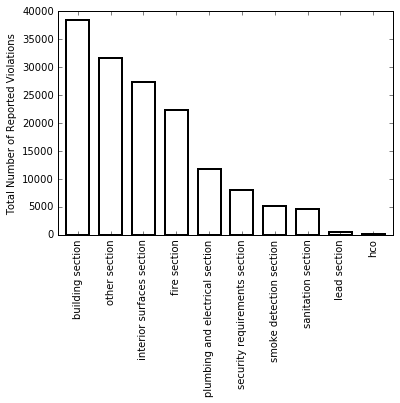

In [304]:
comp_viol['NOV Category Description'].value_counts().plot(kind='bar',ls='-', fc='None', lw=2, 
                                                               zorder=1, position=0.5, width=0.7)
plt.ylabel('Total Number of Reported Violations')

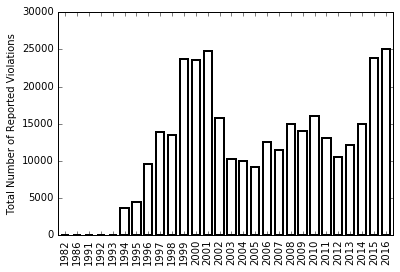

In [327]:
comp_viol['year'].value_counts().sort_index().plot(kind='bar',ls='-', fc='None', lw=2, 
                                                               zorder=1, position=0.5, width=0.7)
plt.ylabel('Total Number of Reported Violations')

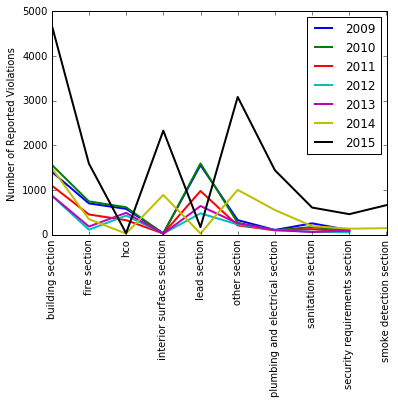

In [325]:
for i in range(2009,2016): 
    comp_viol.loc[np.where(comp_viol['year'] == i)[0], 
                  'NOV Category Description'].value_counts().sort_index().plot(kind='line',ls='-', lw=2, 
                                                                               label=i, rot = 90)

plt.ylabel('Number of Reported Violations')
plt.legend()

In [309]:
comp_viol['Block and Lot Number'] = comp_viol['Block_x'].str.cat(comp_viol['Lot_x'])

Let's try figuring out how to merge the property data with the complaints data. Need to merge information in terms of Block/Lot and year. 

In [275]:
pr['year'] = pr['Closed Roll Fiscal Year'].astype(object)

In [276]:
temp2 = pd.merge(pr, comp_viol, how = 'left', on=['Block and Lot Number', 'year'])

In [279]:
len(temp2), len(pr)

(167276, 142462)

In [290]:
temp2['NOV Category Description'].value_counts()

building section                   5187
other section                      5092
fire section                       2780
interior surfaces section          1849
plumbing and electrical section     999
security requirements section       767
smoke detection section             415
sanitation section                  304
lead section                         44
hco                                   4
Name: NOV Category Description, dtype: int64

In [361]:
temp2.columns.values

array(['Closed Roll Fiscal Year', 'Property Location', 'Neighborhood Code',
       'Neighborhood Code Definition', 'Block and Lot Number',
       'Volume Number', 'Property Class Code',
       'Property Class Code Definition', 'Year Property Built',
       'Number of Bathrooms', 'Number of Bedrooms', 'Number of Rooms',
       'Number of Stories', 'Number of Units',
       'Characteristics Change Date', 'Zoning Code', 'Construction Type',
       'Lot Depth', 'Lot Frontage', 'Property Area in Square Feet',
       'Basement Area', 'Lot Area', 'Lot Code', 'Prior Sales Date',
       'Recordation Date', 'Document Number', 'Document Number 2',
       'Tax Rate Area Code', 'Percent of Ownership',
       'Closed Roll Exemption Type Code',
       'Closed Roll Exemption Type Code Definition',
       'Closed Roll Status Code', 'Closed Roll Misc Exemption Value',
       'Closed Roll Homeowner Exemption Value', 'Current Sales Date',
       'Closed Roll Assessed Fixtures Value',
       'Closed Roll A

Features that are likely important for my model: 
- Neighborhood Code / Neighborhood Code Definition 
- Property Class Code 
- Year Property Built 
- Number of Units 
- Construction Type
- Closed Roll Assessed Personal Prop Value
- Number of violations per property 
- Last Inspection Date (but only available when there are violations) 



In [505]:
his_complaints[['Date Filed', 'Last Inspection Date']].tail()
# last inspection date not so helpful!

,Date Filed,Last Inspection Date
210463,10/31/2016,12/27/2016
210464,12/27/2016,NaN
210465,02/17/2016,NaN
210466,07/31/2012,10/17/2012
210467,10/26/2015,NaN


In [547]:
temp2.columns.values

array(['Closed Roll Fiscal Year', 'Property Location', 'Neighborhood Code',
       'Neighborhood Code Definition', 'Block and Lot Number',
       'Volume Number', 'Property Class Code',
       'Property Class Code Definition', 'Year Property Built',
       'Number of Bathrooms', 'Number of Bedrooms', 'Number of Rooms',
       'Number of Stories', 'Number of Units',
       'Characteristics Change Date', 'Zoning Code', 'Construction Type',
       'Lot Depth', 'Lot Frontage', 'Property Area in Square Feet',
       'Basement Area', 'Lot Area', 'Lot Code', 'Prior Sales Date',
       'Recordation Date', 'Document Number', 'Document Number 2',
       'Tax Rate Area Code', 'Percent of Ownership',
       'Closed Roll Exemption Type Code',
       'Closed Roll Exemption Type Code Definition',
       'Closed Roll Status Code', 'Closed Roll Misc Exemption Value',
       'Closed Roll Homeowner Exemption Value', 'Current Sales Date',
       'Closed Roll Assessed Fixtures Value',
       'Closed Roll A

In [549]:
temp2[['Neighborhood Code', 'Block and Lot Number', 'Closed Roll Assessed Land Value', 'Current Sales Date']]

,Neighborhood Code,Block and Lot Number,Closed Roll Assessed Land Value,Current Sales Date
0,05C,3651002,45891.0,NaN
1,02F,1846013,590915.0,02/15/1991
2,01B,1551051,134160.0,NaN
3,01B,1639005,439405.0,01/18/1989
4,07A,0481002,61367.0,NaN
5,07B,0605025A,730595.0,04/26/1920
6,05H,2719019A,780579.0,12/02/1930
7,05B,1268045,802249.0,07/14/1960
8,02F,1752009,32164.0,NaN
9,09C,3591008A,303627.0,12/23/1998


In [542]:
temp2.columns.values

array(['Closed Roll Fiscal Year', 'Property Location', 'Neighborhood Code',
       'Neighborhood Code Definition', 'Block and Lot Number',
       'Volume Number', 'Property Class Code',
       'Property Class Code Definition', 'Year Property Built',
       'Number of Bathrooms', 'Number of Bedrooms', 'Number of Rooms',
       'Number of Stories', 'Number of Units',
       'Characteristics Change Date', 'Zoning Code', 'Construction Type',
       'Lot Depth', 'Lot Frontage', 'Property Area in Square Feet',
       'Basement Area', 'Lot Area', 'Lot Code', 'Prior Sales Date',
       'Recordation Date', 'Document Number', 'Document Number 2',
       'Tax Rate Area Code', 'Percent of Ownership',
       'Closed Roll Exemption Type Code',
       'Closed Roll Exemption Type Code Definition',
       'Closed Roll Status Code', 'Closed Roll Misc Exemption Value',
       'Closed Roll Homeowner Exemption Value', 'Current Sales Date',
       'Closed Roll Assessed Fixtures Value',
       'Closed Roll A

In [550]:
vio_counts = temp2.groupby(['Block and Lot Number', 
                                    'year'], as_index=False).agg({'Complaint Number':['count'], 
                                                                  'Number of Units':['mean'], 
                                                                  'NOV Type': 'first', 'Location': 'first', 
                                                                  'Date Filed_x': 'first', 
                                                                  'Neighborhood Code': 'first',
                                                                  'Closed Roll Assessed Land Value': 'first',
                                                                  'Current Sales Date': 'first'})

In [551]:
vio_counts['lat'] = vio_counts['Location']['first'].str.split(',').str[0].str.replace('(', '').astype(float)
vio_counts['lon'] = vio_counts['Location']['first'].str.split(',').str[1].str.replace(')', '').astype(float)

Read in Shapefiles

In [456]:
n_reader = sf.Reader('datasets/neighborhoods/geo_export_565bd83a-4c34-4e72-87e1-899e28098e15.shp')
n_records = pd.DataFrame(n_reader.records())
n_shapes = n_reader.shapes()

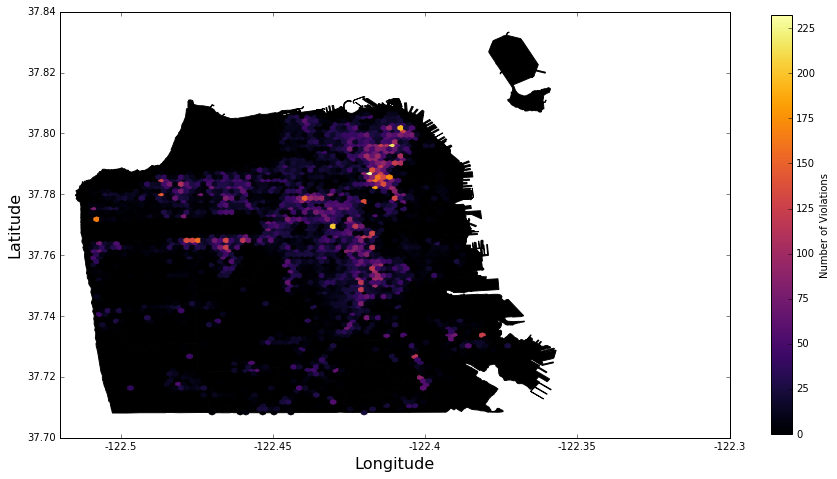

In [480]:
fig,ax = plt.subplots(1,1, figsize=(15,15))

patches1 = []
for i in range(0,len(n_shapes)): 
    if len(n_shapes[i].parts)>1: 
        temp = n_shapes[i].parts
        for j in range(1, len(temp)): 
            barf = pd.DataFrame(n_shapes[i].points[temp[j-1]:temp[j]])
            poly = plt.Polygon(barf[[0,1]], fc='k', ec='k', alpha=1.0, lw=0.9, zorder=2)
            patches1.append(poly)
            plt.gca().add_patch(poly)    
            if (j == len(temp)-1): 
                barf = pd.DataFrame(n_shapes[i].points[temp[j]:])
                poly = plt.Polygon(barf[[0,1]], fc='k', ec='k', alpha=1.0, lw=0.9, zorder=2)
                patches1.append(poly)
                plt.gca().add_patch(poly)                    
    else: 
        barf = pd.DataFrame(n_shapes[i].points)
        poly = plt.Polygon(barf[[0,1]], fc='k', ec='k', alpha=1.0, lw=0.9, zorder=2)
        patches1.append(poly)
        plt.gca().add_patch(poly)
    
    #cenx = np.average([n_shapes[i].bbox[0], n_shapes[i].bbox[2]]) 
    #ceny = np.average([n_shapes[i].bbox[1], n_shapes[i].bbox[3]])
    #ax.annotate(n_reader.records()[i][0], xy=(cenx, ceny), xytext=(cenx-0.005, ceny))

    
plt.axis('scaled')
plt.xlim(-122.52, -122.34)
#plt.ylim(37.8, 37.82)
#plt.xlim(-122.45, -122.4)
plt.xlabel('Longitude', fontsize=16)
plt.ylabel('Latitude', fontsize=16)

# Set the X tick labels so they're useful! 
x_vals = [-122.5, -122.45, -122.4, -122.35, -122.3]
labels = ['-122.5', '-122.45', '-122.4','-122.35', '-122.3']
ax.set_xticks(x_vals)
ax.set_xticklabels(labels)


plt.hexbin(vio_counts['lon'], vio_counts['lat'], gridsize=75, cmap='inferno', 
           C=vio_counts['Complaint Number']['count'], 
           reduce_C_function = np.sum,zorder=3)
plt.colorbar(shrink=0.5, label='Number of Violations')


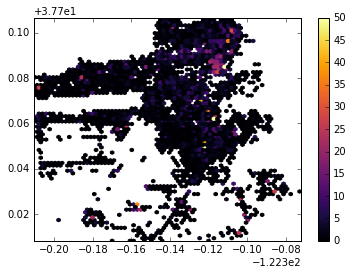

In [515]:
cyear = 2013
indexer = np.where(vio_counts['year']==cyear)[0]
plt.hexbin(vio_counts.loc[indexer, 'lon'], vio_counts.loc[indexer, 'lat'], gridsize=75, cmap='inferno', 
           C=vio_counts.loc[indexer, 'Complaint Number']['count'], 
           reduce_C_function = np.sum, vmax=50)
plt.colorbar()

Now I'll start playing around with the modeling a bit. 

In [585]:
from sklearn.ensemble import RandomForestRegressor

In [553]:
vio_counts.columns.values

array([('Block and Lot Number', ''), ('year', ''),
       ('Date Filed_x', 'first'), ('Location', 'first'),
       ('Complaint Number', 'count'), ('Number of Units', 'mean'),
       ('Current Sales Date', 'first'), ('NOV Type', 'first'),
       ('Closed Roll Assessed Land Value', 'first'),
       ('Neighborhood Code', 'first'), ('lat', ''), ('lon', '')], dtype=object)

In [554]:
vio_counts['year'].value_counts().sort_index()

2007.0    19258
2008.0    19185
2009.0    19140
2010.0    19071
2011.0    18902
2012.0    18965
2013.0    18934
2014.0     9007
Name: year, dtype: int64

In [575]:
# Train/Test Split 
# Because time is a factor, I will select everything up until 2013 as my training. 
Xtrain_temp = vio_counts.loc[np.where(vio_counts['year']<2013)[0], [('Neighborhood Code', 'first'), 
                                                               ('Number of Units', 'mean'), 
                                                               ('Closed Roll Assessed Land Value', 'first')]]
ytrain = vio_counts.loc[np.where(vio_counts['year']<2013)[0], [('Complaint Number', 'count')]]

Xtest_temp = vio_counts.loc[np.where(vio_counts['year']>=2013)[0], [('Neighborhood Code', 'first'), 
                                                               ('Number of Units', 'mean'), 
                                                               ('Closed Roll Assessed Land Value', 'first')]]
ytest = vio_counts.loc[np.where(vio_counts['year']>=2013)[0], [('Complaint Number', 'count')]]

In [578]:
Xtrain = pd.get_dummies(Xtrain_temp, columns = [('Neighborhood Code', 'first')] )
Xtest = pd.get_dummies(Xtest_temp, columns = [('Neighborhood Code', 'first')] )

In [579]:
from sklearn.cross_validation import KFold, StratifiedKFold

kf = KFold(len(Xtrain), n_folds=5, shuffle=True, random_state=42)


In [587]:
rfr = RandomForestRegressor(n_estimators=10)

model = rfr.fit(Xtrain, ytrain)

/Users/kschles/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  app.launch_new_instance()


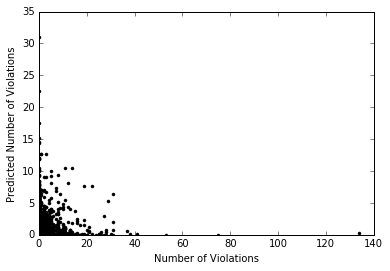

In [592]:
plt.plot(ytest, model.predict(Xtest), 'k.')
plt.xlabel('Number of Violations')
plt.ylabel('Predicted Number of Violations')

In [594]:
plt.hist((ytest - model.predict(Xtest)), bins=20)

ValueError: Wrong number of items passed 27941, placement implies 1

In [181]:
#his_violations[['Complaint Number', 'Block', 'Lot', 'Street Number', 'Street Name', 'Street Suffix', 'Unit']].sort_values(by=['Block', 'Lot'])

In [136]:
his_violations.columns.values

array(['Complaint Number', 'Item Sequence Number', 'Date Filed', 'Block',
       'Lot', 'Street Number', 'Street Name', 'Street Suffix', 'Unit',
       'Status', 'Item', 'Assigned Division', 'Receiving Division',
       'NOV Category Description', 'NOV Item Description',
       'Neighborhoods - Analysis Boundaries', 'Supervisor District',
       'Zipcode', 'Location', 'year'], dtype=object)

In [131]:
#his_complaints.loc[np.where(his_complaints['year']==2007)[0], '']

In [141]:
pr_2007[['Property Location', 'Block and Lot Number']].sort_values(by='Block and Lot Number')

,Property Location,Block and Lot Number
1410133,0000 3800 BEACH ST0000,0013005
102510,0000 0710 NORTH POINT ST0000,0024005
138042,0000 0764 NORTH POINT ST0000,0024010
517659,2704 2700 HYDE ST0000,0024011A
356995,2710 2706 HYDE ST0000,0024011B
146262,2716 2714 HYDE ST0000,0024011C
205446,2722A2720 HYDE ST0000,0024011D
414333,1365 1363 COLUMBUS AV0000,0024015
517066,0000 1331 COLUMBUS AV0000,0024018
499829,0000 1325 COLUMBUS AV0000,0024021


In [99]:
pr_2007.columns.values

array(['Closed Roll Fiscal Year', 'Property Location', 'Neighborhood Code',
       'Neighborhood Code Definition', 'Block and Lot Number',
       'Volume Number', 'Property Class Code',
       'Property Class Code Definition', 'Year Property Built',
       'Number of Bathrooms', 'Number of Bedrooms', 'Number of Rooms',
       'Number of Stories', 'Number of Units',
       'Characteristics Change Date', 'Zoning Code', 'Construction Type',
       'Lot Depth', 'Lot Frontage', 'Property Area in Square Feet',
       'Basement Area', 'Lot Area', 'Lot Code', 'Prior Sales Date',
       'Recordation Date', 'Document Number', 'Document Number 2',
       'Tax Rate Area Code', 'Percent of Ownership',
       'Closed Roll Exemption Type Code',
       'Closed Roll Exemption Type Code Definition',
       'Closed Roll Status Code', 'Closed Roll Misc Exemption Value',
       'Closed Roll Homeowner Exemption Value', 'Current Sales Date',
       'Closed Roll Assessed Fixtures Value',
       'Closed Roll A

In [13]:
his_complaints.columns.values

array(['Complaint Number', 'Date Filed', 'Block', 'Lot', 'Street Number',
       'Street Name', 'Street Suffix', 'Unit', 'Complaint Description',
       'Status', 'NOV Type', 'Receiving Division', 'Assigned Division',
       'Date 1st NOV Issued', 'Date 2nd NOV Issued',
       'Date Referred to City Attorney', 'Director Hearing Date',
       'Last Inspection Date', 'Date Abated', 'Closed Date',
       'Neighborhoods - Analysis Boundaries', 'Supervisor District',
       'Zipcode', 'Location'], dtype=object)

In [25]:
temp = pd.merge(his_complaints, his_violations, on='Complaint Number')

1 complaint can link with multiple violations. 

In [37]:
temp.tail()

,Complaint Number,Date Filed_x,Block_x,Lot_x,Street Number_x,Street Name_x,Street Suffix_x,Unit_x,Complaint Description,Status_x,...,Status_y,Item,Assigned Division_y,Receiving Division_y,NOV Category Description,NOV Item Description,Neighborhoods - Analysis Boundaries_y,Supervisor District_y,Zipcode_y,Location_y
149884,201644341,10/31/2016,5342,002,1750,Lane,St,NaN,there is a leaking coming from upstairs to dow...,active,...,active,inspector comments,Housing Inspection Services,Housing Inspection Services,other section,it is the property owner's responsibility to b...,Bayview Hunters Point,10.0,94124.0,"(37.7314270675413, -122.390670962039)"
149885,201644341,10/31/2016,5342,002,1750,Lane,St,NaN,there is a leaking coming from upstairs to dow...,active,...,active,repair damaged door jamb (1001-b hc),Housing Inspection Services,Housing Inspection Services,building section,replace damaged door jamb at front entry door.,Bayview Hunters Point,10.0,94124.0,"(37.7314270675413, -122.390670962039)"
149886,201644341,10/31/2016,5342,002,1750,Lane,St,NaN,there is a leaking coming from upstairs to dow...,active,...,active,repair toilet (1001f hc),Housing Inspection Services,Housing Inspection Services,plumbing and electrical section,moisture is noted around closet bend and wate...,Bayview Hunters Point,10.0,94124.0,"(37.7314270675413, -122.390670962039)"
149887,201644341,10/31/2016,5342,002,1750,Lane,St,NaN,there is a leaking coming from upstairs to dow...,active,...,active,this notice includes violations for the areas ...,Housing Inspection Services,Housing Inspection Services,building section,1750 lane st.,Bayview Hunters Point,10.0,94124.0,"(37.7314270675413, -122.390670962039)"
149888,201644341,10/31/2016,5342,002,1750,Lane,St,NaN,there is a leaking coming from upstairs to dow...,active,...,active,repair hot water heater (1001f hc),Housing Inspection Services,Housing Inspection Services,plumbing and electrical section,replace or repair leaking hot water heater. i...,Bayview Hunters Point,10.0,94124.0,"(37.7314270675413, -122.390670962039)"
